# Transfer Learning with VGG16 for Deep Space Object Classification





---


[**VGG16**](https://arxiv.org/pdf/1409.1556) is a convolutional neural network architecture with **16 layers** that are trainable (13 convolutional + 3 fully-connected). It was initially trained on the **[ImageNet](https://www.image-net.org/about.php)** dataset.


In Transfer Learning, we take these pre-trained weights, which learned general image features, and reuse them for a new classification task on our own dataset. This approach usually speeds up training and can improve accuracy when the new dataset is smaller or less diverse than ImageNet.

## 1. Add imports

We import **TensorFlow(2.18.0) / Keras** for building and training. We use **matplotlib** for plotting metrics and **numpy** for numerical operations. 'preprocess_input' from VGG16 is used later to normalize images.

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import layers, models
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.utils.class_weight import compute_class_weight

from tqdm import tqdm

# 2. Dataset

In this section, we will load our deep space objects dataset. It includes images from galaxies, nebulae, and star clusters. We will pull it from Google Drive, then split it into train, validation, and test sets. We will also apply basic preprocessing such as input resizing, normalization, etc.

## 2.1 Google Drive mounting


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## 2.2 Dataset augumentation and preprocessing



We apply preprocessing to the images so they match what VGG16 expects. The `preprocessing_function` parameter of the `ImageDataGenerator` lets us use the VGG16-specific `preprocess_input` function. This step normalizes the image pixel values (e.g., scaling and mean subtraction) to be consistent with the data on which VGG16 was originally trained.

In [ ]:
base_dir = '/content/drive/MyDrive/Transfer Learning in Astronomy/ODATA_FINAL'

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_generator = train_datagen.flow_from_directory(
    os.path.join(base_dir, 'train'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

val_generator = test_val_datagen.flow_from_directory(
    os.path.join(base_dir, 'validation'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_val_datagen.flow_from_directory(
    os.path.join(base_dir, 'test'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

print("Class indices:", train_generator.class_indices)


Found 1251 images belonging to 4 classes.
Found 311 images belonging to 4 classes.
Found 389 images belonging to 4 classes.
Class indices: {'clusters': 0, 'galaxies': 1, 'nebulae': 2, 'other': 3}



*   `rotation_range=30`	Objects like galaxies and nebulae can appear in any angle
*   `horizontal_flip`	Telescope images can vary in orientation
*   `zoom_range=0.1`	Slight scale changes simulate object distance variations
*   `width/height shift`	Accounts for minor telescope drift or cropping variation
*   `fill_mode='nearest'`	Avoids artifacts at borders when shifting/rota


# 3. Import VGG16 Model and Build the Classifier

## 3.1 Load and Inspect the VGG16 Architecture

`include_top=False` removes the default classifier, allowing us to add our own layers tailored to our classification task.

In [ ]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

## 3.2 Freeze the Pre-Trained Layers

freezing the layers ensures that the pre-trained feature extraction remains intact during initial training.

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

## 3.3 Build a New Classifier on Top

In [ ]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,847,044 (56.64 MB)

 Trainable params: 132,356 (517.02 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

# 4. Train the Model

Using `checkpoint` will automatically save the model during training — we can resume training from the latest checkpoint

In [ ]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    metrics=['accuracy']
)

checkpoint = ModelCheckpoint(
    '/content/drive/MyDrive/checkpoints/bestVGG.keras',
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)

history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[checkpoint]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 26s/step - accuracy: 0.2560 - loss: 4.8849 
Epoch 1: val_loss improved from inf to 1.56592, saving model to /content/drive/MyDrive/checkpoints/bestVGG.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 1371s 34s/step - accuracy: 0.2569 - loss: 4.8643 - val_accuracy: 0.4277 - val_loss: 1.5659
Epoch 2/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 25s/step - accuracy: 0.4551 - loss: 2.3941 
Epoch 2: val_loss improved from 1.56592 to 1.07893, saving model to /content/drive/MyDrive/checkpoints/bestVGG.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 1319s 32s/step - accuracy: 0.4560 - loss: 2.3886 - val_accuracy: 0.6013 - val_loss: 1.0789
Epoch 3/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 25s/step - accuracy: 0.5412 - loss: 1.9232 
Epoch 3: val_loss improved from 1.07893 to 0.86780, saving model to /content/drive/MyDrive/checkpoints/bestVGG.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 1311s 31s/step - accuracy: 0.5419 - loss: 1.9191 - val_accuracy: 0.6881 - val_loss: 0.8678
Epoch 4/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 25s

## 4.1 Fine-tuning

# 5. Evaluate and Visualize the Model Performance

## 5.1 Plot Training Metrics

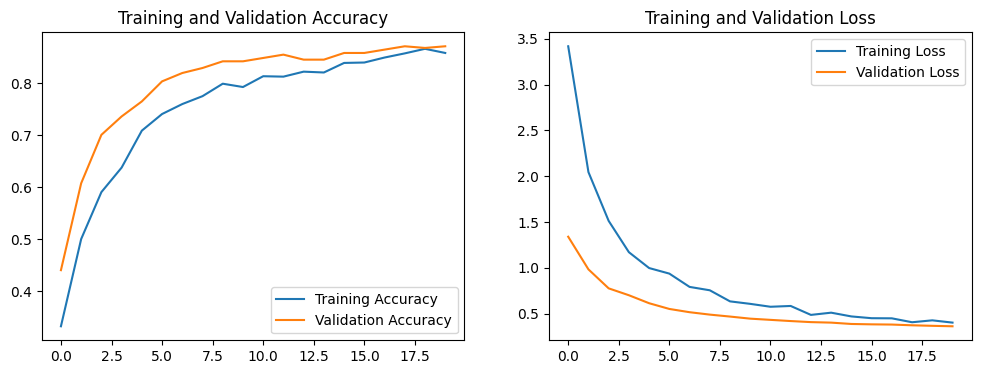

13/13 ━━━━━━━━━━━━━━━━━━━━ 245s 19s/step


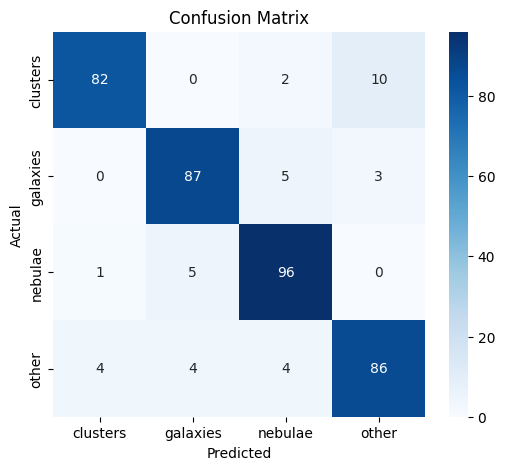

Classification Report:
              precision    recall  f1-score   support

    clusters       0.94      0.87      0.91        94
    galaxies       0.91      0.92      0.91        95
     nebulae       0.90      0.94      0.92       102
       other       0.87      0.88      0.87        98

    accuracy                           0.90       389
   macro avg       0.90      0.90      0.90       389
weighted avg       0.90      0.90      0.90       389



In [ ]:
# First: Accuracy & Loss plots from history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# --- Predict on the test set ---
test_generator.reset()  # Reset generator to start from the beginning
predictions = model.predict(test_generator, verbose=1)
y_pred = np.argmax(predictions, axis=1)

# --- Extract true labels ---
y_true = test_generator.classes

# --- Get class names ---
class_names = list(test_generator.class_indices.keys())

# --- Confusion Matrix ---
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# --- Classification Report ---
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


## 5.2 Final Evaluation on the Test Set

In [ ]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")


13/13 ━━━━━━━━━━━━━━━━━━━━ 241s 18s/step - accuracy: 0.8886 - loss: 0.2865
Test Loss: 0.2991828918457031
Test Accuracy: 0.9023136496543884


# 6. Predict a Specific Image

In [ ]:
img_path = '/content/drive/MyDrive/Transfer Learning in Astronomy/12.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

predictions = model.predict(x)[0]
predicted_class_index = np.argmax(predictions)
predicted_probability = predictions[predicted_class_index] * 100

class_indices = train_generator.class_indices
idx_to_class = {v: k for k, v in class_indices.items()}

predicted_class_name = idx_to_class[predicted_class_index]
print(f"Predicted Class: {predicted_class_name} ({predicted_probability:.2f}%)")

for class_idx, class_prob in enumerate(predictions):
    class_name = idx_to_class[class_idx]
    print(f"{class_name}: {class_prob:.2%}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted Class: other (73.02%)
clusters: 18.65%
galaxies: 4.57%
nebulae: 3.76%
other: 73.02%


# 7. Save the model

In [ ]:
model_save_path = '/content/drive/MyDrive/Transfer Learning in Astronomy/vgg16-4c-20ep.keras'
model.save(model_save_path)

print(f"Model saved successfully at: {model_save_path}")


Model saved successfully at: /content/drive/MyDrive/Transfer Learning in Astronomy/vgg16-4c-20ep.keras


## Embeddings

In [ ]:
def save_embeddings(model, dataset_dir, embedding_layer_name, model_name, output_drive_path):
    embedding_model = Model(inputs=model.input, outputs=model.get_layer(embedding_layer_name).output)

    embeddings = []
    filenames = []

    for root, dirs, files in os.walk(dataset_dir):
        for fname in tqdm(files, desc=f"Processing"):
            fpath = os.path.join(root, fname)
            try:
                img = image.load_img(fpath, target_size=(224, 224))
                img_array = image.img_to_array(img)
                img_array = tf.keras.applications.imagenet_utils.preprocess_input(img_array)
                img_array = np.expand_dims(img_array, axis=0)

                emb = embedding_model.predict(img_array, verbose=0)
                embeddings.append(emb.flatten())
                relative_path = os.path.relpath(fpath, dataset_dir)
                filenames.append(relative_path)
            except Exception as e:
                print(f"Skipping {fname}: {e}")

    embeddings = np.array(embeddings)

    save_path = os.path.join(output_drive_path, f"{model_name}_embeddings.npz")
    np.savez_compressed(save_path, embeddings=embeddings, filenames=filenames)
    print(f"Saved {len(embeddings)} embeddings to {save_path}")


In [ ]:
dataset_dir = '/content/drive/MyDrive/Transfer Learning in Astronomy/ODATA_FINAL'
output_drive_path = '/content/drive/MyDrive/Transfer Learning in Astronomy/Embeddings'
os.makedirs(output_drive_path, exist_ok=True)

embedding_layer_name = 'dense'
model_name = 'vgg'

save_embeddings(model, dataset_dir, embedding_layer_name, model_name, output_drive_path)

Processing: 0it [00:00, ?it/s]
Processing: 0it [00:00, ?it/s]
Processing: 100%|██████████| 79/79 [01:02<00:00,  1.26it/s]
Processing: 0it [00:00, ?it/s]
Processing: 100%|██████████| 95/95 [01:16<00:00,  1.24it/s]
Processing: 0it [00:00, ?it/s]
Processing: 100%|██████████| 327/327 [04:25<00:00,  1.23it/s]

Saved 1951 embeddings to /content/drive/MyDrive/Transfer Learning in Astronomy/Embeddings/vgg_embeddings.npz
